In [57]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [60]:
def load_faster_rcnn_model(model_path, device, num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=False)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)

    return model

In [61]:
faster_rcnn_model = load_faster_rcnn_model('faster_rcnn_best_model2.pth', device, 2)

*********************************

In [62]:
midas_model = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small')
midas_model.eval()
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')

midas_model.to(device)

Using cache found in C:\Users\yilma/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\yilma/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\yilma/.cache\torch\hub\intel-isl_MiDaS_master


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

********************************************

In [63]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [64]:
def detect_objects(image, model, threshold=0.6):
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)
    predictions = model(image_tensor)[0]
    boxes = predictions['boxes'][predictions['scores'] > threshold].cpu().detach().numpy()
    labels = predictions['labels'][predictions['scores'] > threshold].cpu().detach().numpy()
    return boxes, labels

In [65]:
def estimate_depth(image, boxes, model):
    original_shape = image.shape[:2]
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),  # Resize for MiDaS
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    if image_tensor.dim() != 4 or image_tensor.shape[1] != 3:
        raise ValueError(f"Invalid input shape: {image_tensor.shape}, expected [1, 3, H, W]")

    with torch.no_grad():
        prediction = model(image_tensor)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=original_shape,
            mode='bicubic',
            align_corners=False
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    
    object_depths = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        if x1 < x2 and y1 < y2:
            depth_region = depth_map[y1:y2, x1:x2]
            avg_depth = np.mean(depth_region) if depth_region.size > 0 else 0
        else:
            avg_depth = 0
        
        object_depths.append(avg_depth)
    
    return object_depths, depth_map

In [66]:
def plot_results(radar_image, rgb_image, boxes_radar, boxes_rgb, labels_rgb, depths, depth_map):
    fig, axes = plt.subplots(3, 1, figsize=(10, 18))  
    
    radar_vis = radar_image.copy()
    for box in boxes_radar:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(radar_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    axes[0].imshow(radar_vis, cmap='gray')
    axes[0].set_title("Radar Image with Detections")
    
    rgb_vis = rgb_image.copy()
    for i, box in enumerate(boxes_rgb):
        x1, y1, x2, y2 = map(int, box)
        label = labels_rgb[i]
        
        depth = depths[i] if i < len(depths) else 0
        
        cv2.rectangle(rgb_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(rgb_vis, f"Label: {label}, Depth: {depth:.2f}m", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
    depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    depth_vis = cv2.applyColorMap(depth_vis, cv2.COLORMAP_INFERNO)
    axes[1].imshow(depth_vis)
    axes[1].set_title("Depth Map")
    
    axes[2].imshow(rgb_vis)
    axes[2].set_title("RGB Image with Labels and Depths")
    
    plt.tight_layout()
    plt.show()


In [67]:
def plot_results(radar_image, rgb_image, boxes_radar, boxes_rgb, labels_rgb, depths, depth_map=None):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    radar_vis = radar_image.copy()
    for box in boxes_radar:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(radar_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    axes[0].imshow(radar_vis, cmap='gray')
    axes[0].set_title("Radar Image with Detections")
    
    rgb_vis = rgb_image.copy()
    for i, box in enumerate(boxes_rgb):
        x1, y1, x2, y2 = map(int, box)
        label = labels_rgb[i]
        cv2.rectangle(rgb_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(rgb_vis, f"Label: {label}, Depth: {depths[i]:.2f}m", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Plot depth map
    axes[1].imshow(depth_map, cmap='inferno')
    axes[1].set_title("Depth Map")
    
    axes[2].imshow(rgb_vis)
    axes[2].set_title("RGB Image with Labels and Depths")
    
    plt.show()

In [77]:
def plot_results(radar_image, rgb_image, boxes_radar, boxes_rgb, labels_rgb, depths, depth_map=None):
    fig, axes = plt.subplots(3, 1, figsize=(8, 18))  # Vertical Layout
    
    radar_vis = radar_image.copy()
    for box in boxes_radar:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(radar_vis, (x1, y1), (x2, y2), (0, 255, 0), 3)
    
    axes[0].imshow(radar_vis, cmap='gray')
    axes[0].set_title("Radar Image with Detections", fontsize=14)
    axes[0].axis('off')
    axes[0].text(
        0.5, -0.1, 
        "Object(s) detected by radar. Highlighted in green boxes.",
        fontsize=12, color='black', ha='center', va='center',
        transform=axes[0].transAxes
    )
    
    if depth_map is not None:
        axes[1].imshow(depth_map, cmap='inferno')
        axes[1].set_title("Depth Map", fontsize=14)
        axes[1].axis('off')
        axes[1].text(
            0.5, -0.1, 
            "Depth map visualization",
            fontsize=12, color='black', ha='center', va='center',
            transform=axes[1].transAxes
        )
    
    rgb_vis = rgb_image.copy()
    text_list = []
    for i, box in enumerate(boxes_rgb):
        x1, y1, x2, y2 = map(int, box)
        label = labels_rgb[i]
        if label == 1:
            label = "Drone"
        cv2.rectangle(rgb_vis, (x1, y1), (x2, y2), (255, 0, 0), 3)
        text = f"Label: {label}, Estimated Depth: {depths[i]:.2f}m"
        text_list.append(text)
        cv2.putText(
            rgb_vis, 
            text, 
            (x1, max(y1 - 10, 20)),
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.8,  
            (255, 0, 0), 
            2,
            cv2.LINE_AA
        )
    
    axes[2].imshow(rgb_vis)
    axes[2].set_title("RGB Image with Labels and Depths", fontsize=14)
    axes[2].axis('off')
    axes[2].text(
        0.5, -0.1, 
        "\n".join(text_list),
        fontsize=12, color='black', ha='center', va='center',
        transform=axes[2].transAxes
    )
    
    plt.tight_layout()
    plt.show()

In [78]:
def fusion_pipeline(radar_image_path, rgb_image_path):
    # Load images
    radar_image = load_image(radar_image_path)
    rgb_image = load_image(rgb_image_path)
    
    boxes_radar, _ = detect_objects(radar_image, faster_rcnn_model)
    
    if len(boxes_radar) == 0:
        print("No objects detected in the radar image.")
        return
    
    depths, depth_map = estimate_depth(radar_image, boxes_radar, midas_model)
    
    boxes_rgb, labels_rgb = detect_objects(rgb_image, faster_rcnn_model)
    
    plot_results(radar_image, rgb_image, boxes_radar, boxes_rgb, labels_rgb, depths, depth_map)

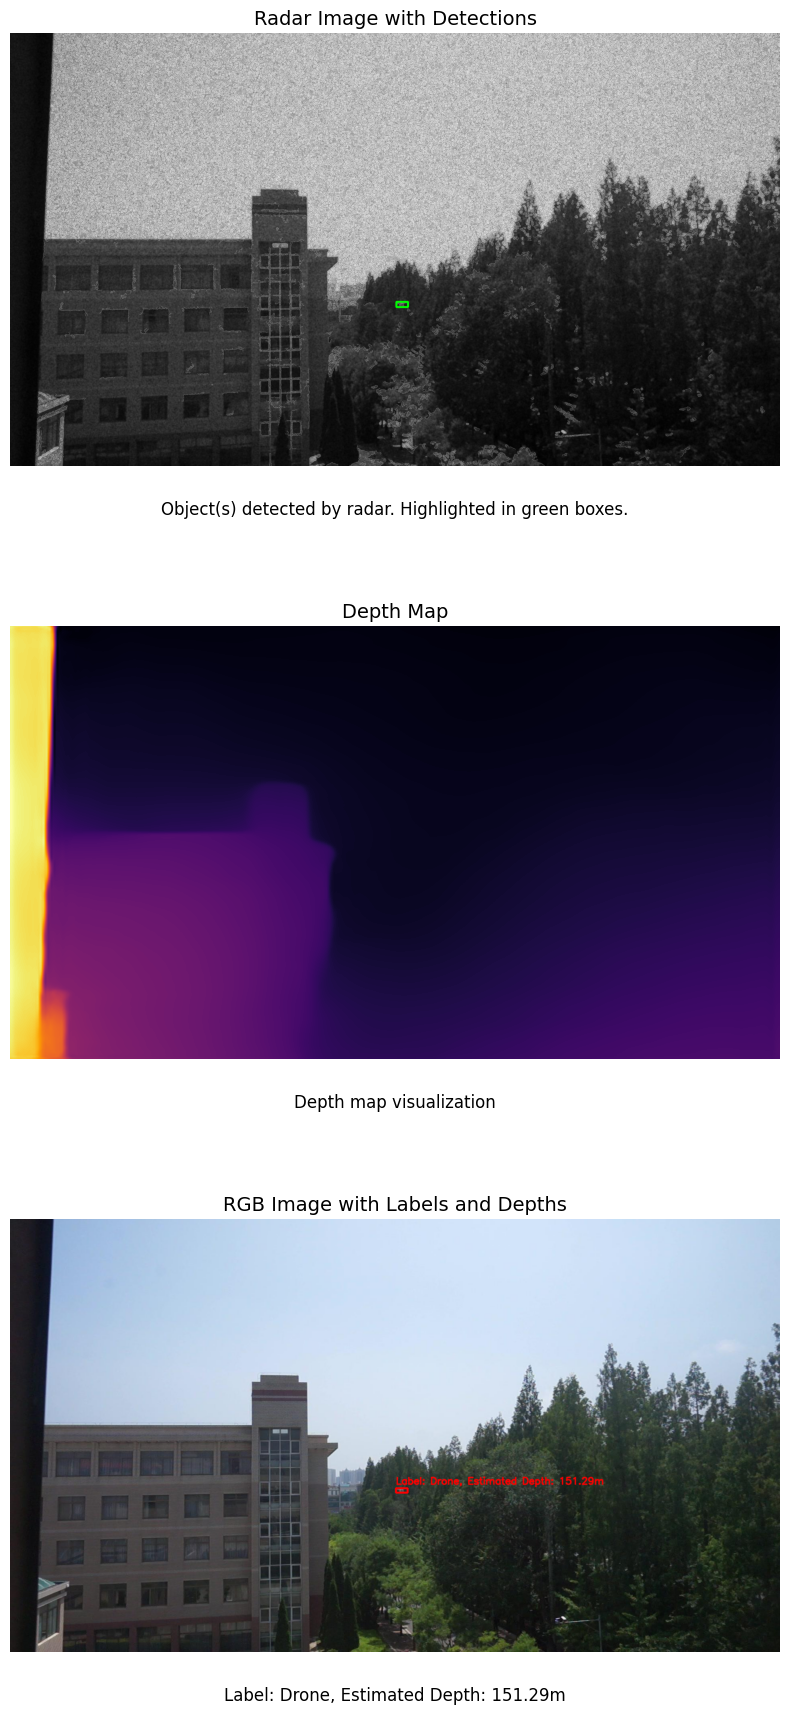

In [96]:
if __name__ == "__main__":
    radar_image_path = r"C:\Users\yilma\Desktop\graduation dataset\3\test_radar\img\00459.jpg"
    rgb_image_path = r"C:\Users\yilma\Desktop\graduation dataset\3\test\img\00459.jpg"
    fusion_pipeline(radar_image_path, rgb_image_path)